In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

# Importing the sound file

### We are using the Librosa Package for breaking down the sound file
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3955228.svg)](https://doi.org/10.5281/zenodo.3955228)

This package will be used to break the music into components parts that can be used as features

In [2]:
music = r'Source_Data/Micro_Motion_2012/sound_data/nm12stimuli.wav'
y, sr = lib.load(music)

In [3]:
#Librosa brings the music in as a 1D array of amplitudes and a scalar value for the frequency in Hz (220)
type(y), type(sr)

(numpy.ndarray, int)

In [4]:
y.shape, sr

((3895132,), 22050)

At a duration of 2 mins and 56 secs and a sample rate of 22 kHz there are 176 second x 22050 cycles = 3895132 data points

In [5]:
#This is how the clip actually sounds. The first 3 minutes the paticipants stand in silence and then 
#this clip is used for the remaining 3 minutes
#Audio(data=y, rate=sr)

The segments of music are as follows:

1 - Lento (#3) from György Ligeti’s Ten Pieces for Wind Quintet (20s)<br>
2 - Allegro con delicatezza (#8) from György Ligeti’s Ten Pieces for Wind Quintet (15s)<br>
3 - Adagio from Joaquin Rodrigo's Concierto de Aranjuez (40s)<br>
4 - Winter movement from Vivaldi's The Four Seasons (20s)<br>
5 - Left & Right by D'Angelo, featuring Method Man & Redman (35s)<br>
6 - Salsa (20s)<br>
7 - EDM (30s)<br>

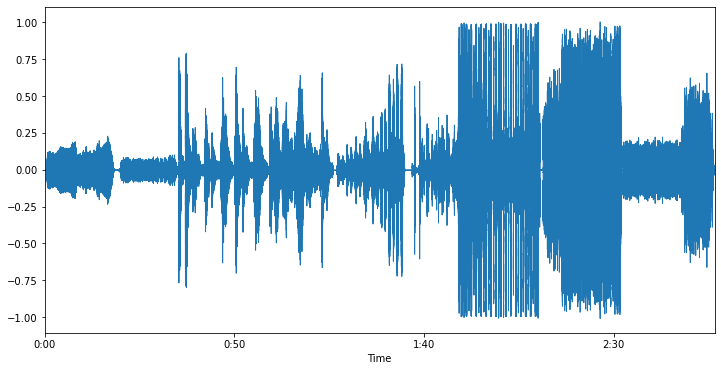

In [6]:
#The waveform plot gives a good represenation of the different types of music being played
plt.figure(figsize=(12, 6))
librosa.display.waveplot(y, sr)
plt.show()

In [7]:
#taking the short time fast Fourier transform and apply log scale to the amplitude
d = librosa.stft(y)
log = librosa.amplitude_to_db(np.abs(d), ref=np.max)

In [8]:
#Creating data for a Constant_Q chromagram which shows musical notes as opposed to frequencies. The hop_length is set to 
#give the maximum time windows within the octave constraints. This will need to upsample the ~15k segments so that they 
#match the 100 samples per second of the motion data (see EDA notebook)
chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=256)

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


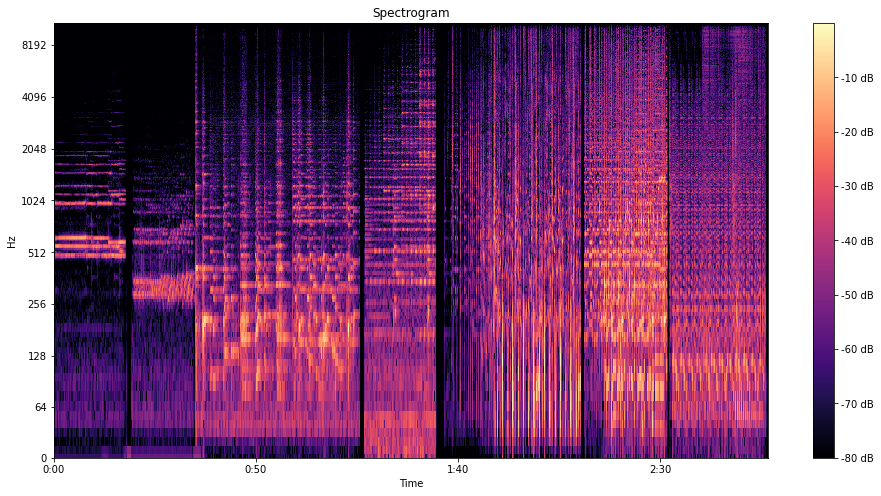

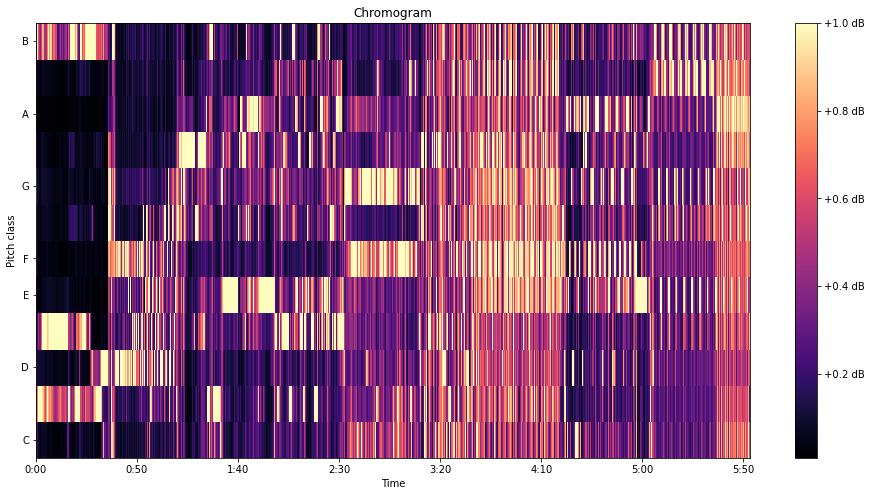

In [9]:
#Plotting a log spectrogram
plt.figure(figsize=(16, 8))
librosa.display.specshow(log, y_axis='log', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

#Plotting a chromagram
plt.figure(figsize=(16, 8))
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar(img, format='%+.1f dB')
plt.title('Chromogram')

plt.show()

You can again see a signifcant difference in the visualization between the different segments including the breaks for change over between music.

For additional information about these plots see the librosa documentation
https://librosa.org/doc/latest/index.html

Or this helpful medium post
https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53#:~:text=A%20mel%20spectrogram%20is%20a%20spectrogram%20where,the%20frequencies%20are%20converted%20to%20the%20mel%20scale.

In [10]:
#Transform the chroma_cqt data into a DataFrame
chromadf = pd.DataFrame(chroma)
chromadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Columns: 15216 entries, 0 to 15215
dtypes: float32(15216)
memory usage: 713.4 KB


In [11]:
#Adding column labels to the dataframe based on 12 equal musical notes
notes = {0:'C', 1:'C_sharp', 2:'D', 3:'D_sharp', 4:'E', 5:'F', 6:'F_sharp', 7:'G', 8:'G_sharp', 9:'A', 10:'A_sharp', 11:'B'}
ch_tidy = chromadf.T.rename(columns=notes)
print(ch_tidy.shape)
ch_tidy.head()

(15216, 12)


,C,C_sharp,D,D_sharp,E,F,F_sharp,G,G_sharp,A,A_sharp,B
0,0.391866,0.271475,0.543743,0.414470,0.615711,0.905505,0.693868,1.0,0.873349,0.428765,0.196232,0.178688
1,0.391006,0.270759,0.542460,0.419167,0.611465,0.895052,0.696120,1.0,0.865096,0.424725,0.202718,0.177431
2,0.384290,0.269616,0.530845,0.424728,0.596871,0.879191,0.701280,1.0,0.854621,0.410783,0.205452,0.178596
3,0.368410,0.266402,0.511752,0.433351,0.582881,0.878751,0.706602,1.0,0.850467,0.397394,0.211017,0.174648
4,0.356740,0.260931,0.492235,0.435323,0.570510,0.877007,0.707534,1.0,0.849687,0.381047,0.214705,0.177209


The data is assembled with each row representing a snapshot of the music at a rate of 1 hundreth of a second (centisecond). each column represents a note and the values in each column represent the intensity of the note at that snapshot. Looking at the Chromogram above, you can see the notes represented on the y-axis with their color denoting their intensity (lighter = stronger/louder)

Additional information about the note breakdown can be found here
https://en.wikipedia.org/wiki/12_equal_temperament

In [12]:
#Exporting dataframe using the feather package for use in other notebooks
ch_tidy.to_pickle('DFS/music_clean.pkl')